**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

> **Load the `clean data` preprocessed in `Assignment 1`, then handle it to be used with `RNNs`**

### Import Libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
import contractions
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding,SimpleRNN,Flatten,BatchNormalization
from sklearn.metrics import accuracy_score, classification_report,f1_score
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load Dataset

In [8]:
df = pd.read_csv("/content/Hate Speech.tsv", sep= "\t", index_col='id')
df.head(10)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
7,0,@user camping tomorrow @user @user @user @user...
8,0,the next school year is the year for exams.ð...
9,0,we won!!! love the land!!! #allin #cavs #champ...


In [9]:
print(df.duplicated().sum())


2404


In [10]:
df = df.drop_duplicates()


In [61]:
train, test = train_test_split(df, test_size=0.2, random_state=1234)


In [62]:
X_train, X_val, y_train, y_val = train_test_split(train['tweet'], train['label'], test_size=0.2, random_state=1234)


In [63]:
# Now, process the test data
X_test = test['tweet']
y_test = test['label']

### Preprocessing

In [64]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # remove the tab and newline
    text = text.replace('\n', '').replace('\t', ' ')

    # remove extra white space
    text = re.sub(r'\s+', ' ', text)

    # remove contractions
    text = contractions.fix(text)

    # remove the punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # remove emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # remove text elongation
    text = re.sub(r'(.)\1+', r'\1', text)



    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'also', 'would', 'could', 'may', 'might', 'must', 'need'}
    stop_words.update(custom_stopwords)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [67]:
# apply the preprocessing function
X_train_tokens = [preprocess_text(doc) for doc in X_train]
X_val_tokens = [preprocess_text(doc) for doc in X_val]
X_test_tokens = [preprocess_text(doc) for doc in X_test]

In [68]:
# with respect to tokens not sentence length
max_sequence_len = 0
for sentence in X_train_tokens:
    max_sequence_len = max(len(sentence), max_sequence_len)
print(max_sequence_len)

2479


In [69]:
MAX_FEATURES = 20000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=2000,
                               output_mode='int')

In [71]:
vectorizer.adapt(X_train_tokens)


In [72]:
X_train = vectorizer(X_train_tokens)
X_val = vectorizer(X_val_tokens)
X_test = vectorizer(X_test_tokens)


In [78]:

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE to your data and resample
X_train, y_train = smote.fit_resample(X_train, y_train)

### Modelling

Simple RNN

In [16]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(SimpleRNN(32))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build()


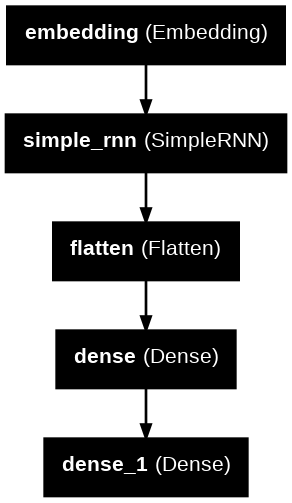

In [17]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 78s 129ms/step - accuracy: 0.9202 - loss: 0.2854 - val_accuracy: 0.9301 - val_loss: 0.2540
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9284 - loss: 0.2589 - val_accuracy: 0.9301 - val_loss: 0.2537
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 81s 125ms/step - accuracy: 0.9302 - loss: 0.2543 - val_accuracy: 0.9301 - val_loss: 0.2542
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9300 - loss: 0.2544 - val_accuracy: 0.9301 - val_loss: 0.2539
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9335 - loss: 0.2454 - val_accuracy: 0.9301 - val_loss: 0.2541


In [20]:

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step
Macro F1-score: 0.48


LSTM

In [21]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build()


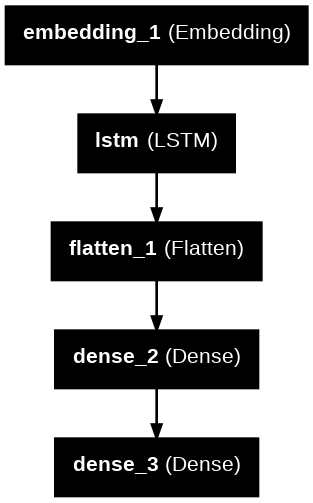

In [22]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.9228 - loss: 0.2761 - val_accuracy: 0.9301 - val_loss: 0.2628
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.9308 - loss: 0.2530 - val_accuracy: 0.9301 - val_loss: 0.2578
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9290 - loss: 0.2582 - val_accuracy: 0.9301 - val_loss: 0.2539
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.9314 - loss: 0.2507 - val_accuracy: 0.9301 - val_loss: 0.2562
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.9328 - loss: 0.2474 - val_accuracy: 0.9301 - val_loss: 0.2540


In [25]:

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Macro F1-score: 0.48


In [26]:
print("Classification Report on Valdtion:\n", classification_report(y_test, y_pred))


Classification Report on Valdtion:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5454
           1       0.00      0.00      0.00       373

    accuracy                           0.94      5827
   macro avg       0.47      0.50      0.48      5827
weighted avg       0.88      0.94      0.91      5827



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bi-direction RNN

In [20]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(SimpleRNN(32)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.build()

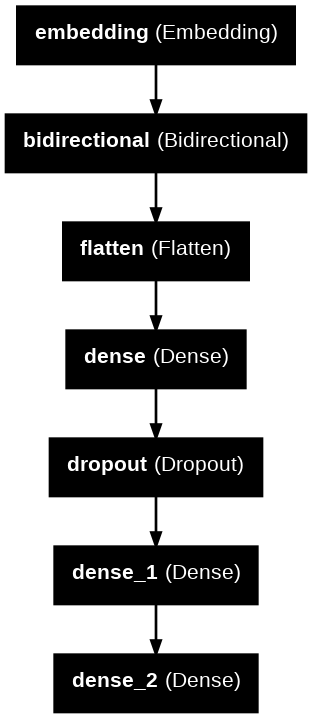

In [21]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 154s 251ms/step - accuracy: 0.9179 - loss: 0.2622 - val_accuracy: 0.9451 - val_loss: 0.1635
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 197s 245ms/step - accuracy: 0.9525 - loss: 0.1346 - val_accuracy: 0.9425 - val_loss: 0.1599
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 203s 247ms/step - accuracy: 0.9673 - loss: 0.0947 - val_accuracy: 0.9434 - val_loss: 0.1819
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 202s 247ms/step - accuracy: 0.9815 - loss: 0.0543 - val_accuracy: 0.9273 - val_loss: 0.2143
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 202s 247ms/step - accuracy: 0.9894 - loss: 0.0335 - val_accuracy: 0.9384 - val_loss: 0.2456


In [24]:

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step
Macro F1-score: 0.74


In [25]:
print("Classification Report on Valdtion:\n", classification_report(y_test, y_pred))


Classification Report on Valdtion:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      5454
           1       0.66      0.54      0.59       373

    accuracy                           0.95      5827
   macro avg       0.81      0.76      0.78      5827
weighted avg       0.95      0.95      0.95      5827



Bi-direction LSTM

In [52]:
model2 = Sequential()
model2.add(Embedding(MAX_FEATURES+1,32))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(1,activation = 'sigmoid'))


In [53]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [54]:
model2.fit(X_train,y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.9284 - loss: 0.2609 - val_accuracy: 0.9526 - val_loss: 0.1375
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 85s 115ms/step - accuracy: 0.9726 - loss: 0.0805 - val_accuracy: 0.9556 - val_loss: 0.1317
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9894 - loss: 0.0362 - val_accuracy: 0.9543 - val_loss: 0.1554
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 85s 115ms/step - accuracy: 0.9948 - loss: 0.0171 - val_accuracy: 0.9562 - val_loss: 0.1965
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 79s 109ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9556 - val_loss: 0.2456


In [55]:

# Predict probabilities
y_pred_prob = model2.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
Macro F1-score: 0.81


#### Evaluation

In [27]:
print("Classification Report on Valdtion:\n", classification_report(y_test, y_pred))


Classification Report on Valdtion:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5454
           1       0.70      0.57      0.63       373

    accuracy                           0.96      5827
   macro avg       0.84      0.78      0.80      5827
weighted avg       0.95      0.96      0.95      5827



In [36]:
model3 = Sequential()
model3.add(Embedding(MAX_FEATURES+1,32))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(1,activation = 'sigmoid'))


In [37]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
model3.fit(X_train,y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 74s 116ms/step - accuracy: 0.9320 - loss: 0.2549 - val_accuracy: 0.9509 - val_loss: 0.1377
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 64s 110ms/step - accuracy: 0.9696 - loss: 0.0865 - val_accuracy: 0.9567 - val_loss: 0.1271
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.9876 - loss: 0.0389 - val_accuracy: 0.9552 - val_loss: 0.1570
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 63s 109ms/step - accuracy: 0.9930 - loss: 0.0235 - val_accuracy: 0.9537 - val_loss: 0.1638
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 86s 116ms/step - accuracy: 0.9968 - loss: 0.0120 - val_accuracy: 0.9519 - val_loss: 0.2104


In [39]:

# Predict probabilities
y_pred_prob = model3.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step
Macro F1-score: 0.80


In [82]:
model4 = Sequential()
model4.add(Embedding(MAX_FEATURES+1,32))
model4.add(Bidirectional(LSTM(32,return_sequences= True)))
model4.add(Bidirectional(LSTM(16)))
model4.add(Dense(128,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(1,activation = 'sigmoid'))


In [83]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model4.fit(X_train,y_train, epochs=20,batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping_callback])

Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 217s 195ms/step - accuracy: 0.6332 - loss: 0.6285 - val_accuracy: 0.8548 - val_loss: 0.4069
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 260s 194ms/step - accuracy: 0.7905 - loss: 0.4599 - val_accuracy: 0.8599 - val_loss: 0.3705
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 270s 201ms/step - accuracy: 0.8724 - loss: 0.3076 - val_accuracy: 0.8219 - val_loss: 0.4512
Epoch 4/20


In [77]:

# Predict probabilities
y_pred_prob = model4.predict(X_test)

# Convert to binary labels (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro F1-score: {f1:.2f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step
Macro F1-score: 0.81


#### Done!